In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

start_date = pd.to_datetime('1990-01-01')

## If we try to directly use the data from Fred

In [68]:
gdp_df = pd.read_csv('../Github/Data/Fred_Data/Quarterly.csv', header = [0], index_col= [0], parse_dates=True)

default_value = None

gdp_df['GDPC1'] = np.array([np.float(value) if value != '.' else default_value for value in gdp_df['GDPC1']])
gdp_df['GDPPOT'] = np.array([np.float(value) if value != '.' else default_value for value in gdp_df['GDPPOT']])

gdp_df = gdp_df.dropna(how = 'any')

C:\Users\asus\AppData\Local\Temp\ipykernel_23228\1102346178.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gdp_df['GDPC1'] = np.array([np.float(value) if value != '.' else default_value for value in gdp_df['GDPC1']])
C:\Users\asus\AppData\Local\Temp\ipykernel_23228\1102346178.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gdp_df

In [69]:
gdp_df["LN Real GDP"] = 0
for i in gdp_df.index:
    gdp_df.loc[i, 'LN Real GDP'] = np.log(gdp_df.loc[i, 'GDPC1'])

gdp_df["LN Potential GDP"] = 0
for i in gdp_df.index:
    gdp_df.loc[i, 'LN Potential GDP'] = np.log(gdp_df.loc[i, 'GDPPOT'])

gdp_df['Resource_GAP'] = gdp_df['LN Real GDP'] - gdp_df['LN Potential GDP']

In [70]:
# gdp_df['Resource_GAP'] = np.log(gdp_df['GDPC1']) - np.log(gdp_df['GDPPOT'])

In [71]:
pce_df = pd.read_csv('../Github/Data/Fred_Data/fredgraph_PCE.csv', header = [0], index_col= [0], parse_dates=True)
pce_df = pce_df.drop('GDPC1', axis = 1)

pce_df['PCEPI_CH1'] = np.array([np.float(value) if value != '.' else default_value for value in pce_df['PCEPI_CH1']])

macro_df = pd.concat([pce_df, gdp_df[['Resource_GAP']]], axis = 1)
macro_df = macro_df.dropna(how = 'any')

C:\Users\asus\AppData\Local\Temp\ipykernel_23228\3134188369.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pce_df['PCEPI_CH1'] = np.array([np.float(value) if value != '.' else default_value for value in pce_df['PCEPI_CH1']])


In [72]:
macro_df['Traditional Taylor Rule'] = 2 + (macro_df['PCEPI_CH1'] - 2) / 2 + 0.5 * 100 * macro_df['Resource_GAP']

In [73]:
real_ffr = pd.read_csv('../Github/Data/Raw Data/US FFR.csv', header=[0])
col_index = real_ffr.pop('Date')
col_index = pd.to_datetime(col_index) + pd.Timedelta(days = 10)
col_index = col_index.dt.to_period('M').dt.to_timestamp()

col_index[0] = pd.to_datetime('2023-10-01')

real_ffr.index = col_index
real_ffr = real_ffr.sort_index()

C:\Users\asus\AppData\Local\Temp\ipykernel_23228\4131650138.py:6: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  col_index[0] = pd.to_datetime('2023-10-01')


In [74]:
ffr_comparions = pd.concat([real_ffr, macro_df[['Traditional Taylor Rule']].shift(2)], axis = 1).dropna(how = 'any')
ffr_comparions = ffr_comparions[start_date:]

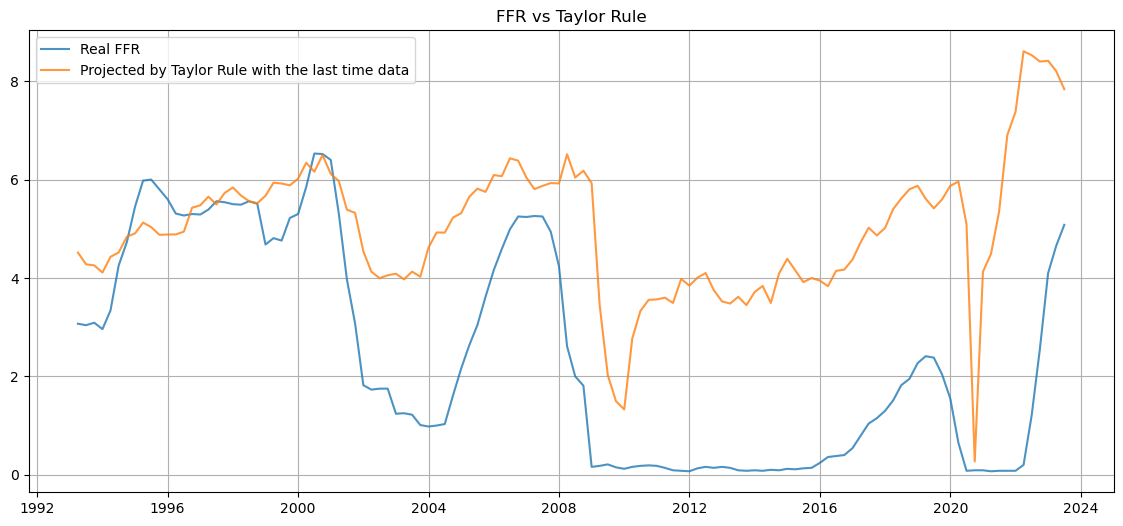

In [75]:
plt.figure(figsize=(14, 6))
plt.plot(ffr_comparions['Mid Price'][13:], alpha = 0.8, label = 'Real FFR')
plt.plot(ffr_comparions['Traditional Taylor Rule'][13:], alpha = 0.8, label = 'Projected by Taylor Rule with the last time data')

plt.grid()
plt.title('FFR vs Taylor Rule')
plt.legend()
plt.show()

In [76]:
mse = np.mean((ffr_comparions['Mid Price'][13:] - ffr_comparions['Traditional Taylor Rule'][13:])**2)
print(mse)

10.126422057868945


In [77]:
ffr_comparions = pd.concat([real_ffr, macro_df[['Traditional Taylor Rule']].shift(1)], axis = 1).dropna(how = 'any')
ffr_comparions = ffr_comparions[start_date:]

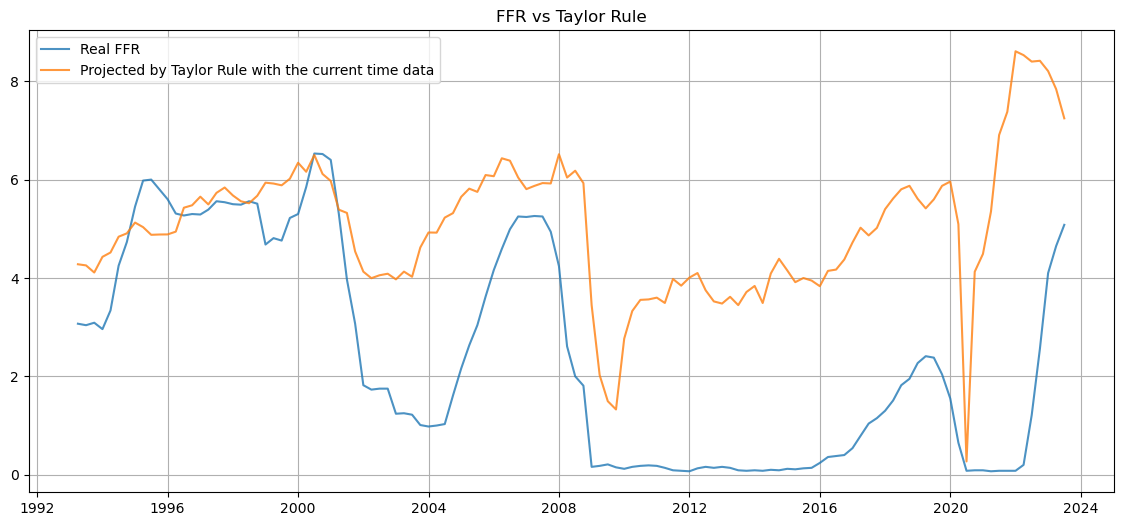

In [78]:
plt.figure(figsize=(14, 6))
plt.plot(ffr_comparions['Mid Price'][13:], alpha = 0.8, label = 'Real FFR')
plt.plot(ffr_comparions['Traditional Taylor Rule'][13:], alpha = 0.8, label = 'Projected by Taylor Rule with the current time data')

plt.grid()
plt.title('FFR vs Taylor Rule')
plt.legend()
plt.show()

In [79]:
mse = np.mean((ffr_comparions['Mid Price'][13:] - ffr_comparions['Traditional Taylor Rule'][13:])**2)
print(mse)

10.402833989771574


### It is found that the prediction is not accurate, as it is because the GDP data has some issues

## Instead we use the data from Fred Atlanta to measure the Resource GAP

In [80]:
# macro_df = pd.concat([pce_df, gdp_df[['CBOT_RGAP']]], axis = 1)
# macro_df = macro_df.dropna(how = 'any')

In [81]:
# macro_df['Traditional Taylor Rule'] = 2 + (macro_df['PCEPI_CH1'] - 2) / 2 + 0.5 * macro_df['CBOT_RGAP']

In [82]:
macro_df = pd.concat([macro_df, real_ffr], axis = 1)

In [83]:
macro_df.to_csv('../Github/Data/calculated_macro.csv')